[Source](https://arxiv.org/pdf/1706.01427.pdf)

#Data
## Sort-of-CLEVR

Sort-of-CLEVR is simplified version of [CLEVR](http://cs.stanford.edu/people/jcjohns/clevr/).This is composed of 10000 images (9800 for training and 200 for testing) and 20 questions (10 relational questions and 10 non-relational questions) per each image. 6 colors (red, green, blue, cyan, gray, light-blue) are assigned to randomly chosen shape (square or circle), and placed in a image.

Non-relational questions are composed of 3 subtypes:

1. Shape of certain colored object
2. Horizontal location of certain colored object : whether it is on the left side of the image or right side of the image
3. Vertical location of certain colored object : whether it is on the upside of the image or downside of the image

Theses questions are "non-relational" because the agent only need to focus on certain object.

Relational questions are composed of 3 subtypes:

1. Shape of the object which is closest to the certain colored object
2. Shape of the object which is furthest to the certain colored object
3. Number of objects which have the same shape with the certain colored object

These questions are "relational" because the agent has to consider the relations between objects.

Questions are encoded into a vector of size of 11 : 6 for one-hot vector for certain color among 6 colors, 2 for one-hot vector of relational/non-relational questions. 3 for one-hot vector of 3 subtypes.

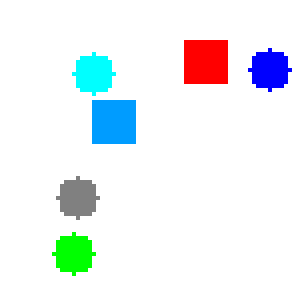

e.g., with the sample image shown, we can generate non-relational questions like:

1. What is the shape of the red object? => Rectangle
2. Is green object placed on the left side of the image? => yes
3. Is gray object placed on the top half of the image? => no

And relational questions:

1. What is the shape of the object closest to the red object? => circle (blue)
2. What is the shape of the object furthest to the cyan object? => circle (green)
3. How many objects have same shape with the blue object? => 4 (circles)

##State Descriptions
State of each image is described by 6 vectors, one each for the 6 objects in the image. State of each object in an image is described using a fixed length vector of size 14 where the first 6 bits denote color of the object, next two bits denote the shape of the object (rectangle/circle), next two bits denote the x and y coordinates of the objects' center scaled using image size, next two bits denote the objects material (smooth/shiny), and final two bits denote the objects' size (small/big).
e.g. the image shown above can be described as below :

| color1 | color2 | color3 | color4 | color5 | color6 | rectangle | circle | x_scaled | y_scaled | smooth | shiny | small | big |
| ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ | ------ |
| 1 | 0 | 0 | 0 | 0 | 0 | 0 | 1 | 0.89333333 | 0.22666667 | 1 | 0 | 1 | 0 |
| 0 | 1 | 0 | 0 | 0 | 0 | 0 | 1 | 0.24 | 0.84 | 1 | 0 | 1 | 0 |
| 0 | 0 | 1 | 0 | 0 | 0 | 1 | 0 | 0.68 | 0.2 | 1 | 0 | 1 | 0 |
| 0 | 0 | 0 | 1 | 0 | 0 | 1 | 0 | 0.37333333 | 0.4 | 1 | 0 | 1 | 0 |
| 0 | 0 | 0 | 0 | 1 | 0 | 0 | 1 | 0.25333333 | 0.65333333 | 1 | 0 | 1 | 0 |
| 0 | 0 | 0 | 0 | 0 | 1 | 0 | 1 | 0.30666667 | 0.24 | 1 | 0 | 1 | 0 |

Note that all the objects in this dataset are smooth and small.

These state descriptions can be used directly for training a relational network by treating each row as an object for $g_{\theta}$'s input

#Relational Networks

An RN is a neural network module with a structure primed for relational reasoning. The design philosophy behind RNs is to constrain the functional form of a neural network so that it captures the core common properties of relational reasoning. In other words, the capacity to compute relations is baked into the RN architecture without needing to be learned, just as the capacity to reason about spatial, translation invariant properties is built-in to CNNs, and the capacity to reason about sequential dependencies is built into recurrent neural networks.

In its simplest form the RN is a composite function:

$RN(O) = f_{\phi}(\sum_{i,j}g_{\theta}(o_i,o_j))$

where the input is a set of “objects” $O = {o_1, o_2, ..., o_n}, o_i \in R^m$ is the ith object, and $f_{\phi}$ and $g_{\theta}$ are functions with parameters $\phi$ and $\theta$, respectively. For our purposes, $f_{\phi}$ and $g_{\theta}$ are MLPs, and the parameters are learnable synaptic weights, making RNs end-to-end differentiable. We call the output of $g_{\theta}$ a “relation”; therefore, the role of $g_{\theta}$ is to infer the ways in which two objects are related, or if they are even related at all.


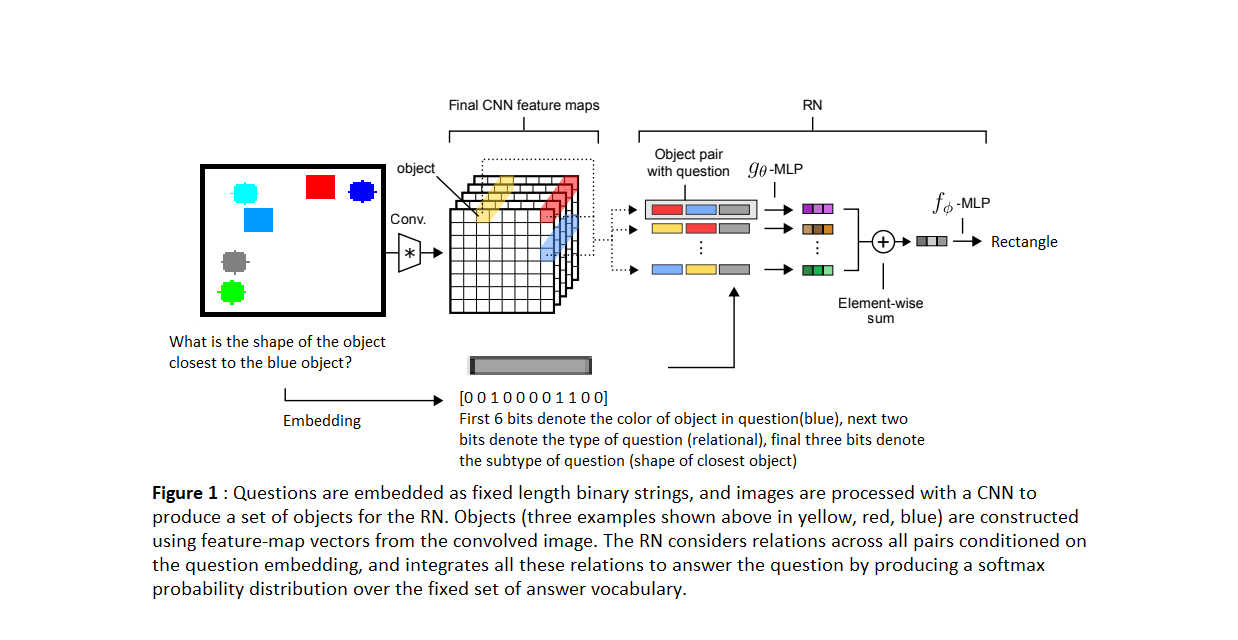

RNs have three notable strengths: they learn to infer relations, they are data efficient, and they operate on a set of objects – a particularly general and versatile input format – in a manner that is order invariant.

1. RNs learn to infer relations :
  
  The functional form in equation above dictates that an RN should consider the potential relations between all object pairs. This implies that an RN is not necessarily privy to which object relations actually exist, nor to the actual meaning of any particular relation. Thus, RNs must learn to infer the existence and implications of object relations. In graph theory parlance, the input can be thought of as a complete and directed graph whose nodes are objects and whose edges denote the object pairs whose relations should be considered. Although we focus on this “all-to-all” version of the RN throughout this paper, this RN definition can be adjusted to consider only some object pairs. Similar to Interaction Networks, to which RNs are related, RNs can take as input a list of only those pairs that should be considered, if this information is available. This information could be explicit in the input data, or could perhaps be extracted by some upstream mechanism.

2. RNs are data efficient :
  
  RNs use a single function $g_{\theta}$ to compute each relation. This can be thought of as a single function operating on a batch of object pairs, where each member of the batch is a particular object-object pair from the same object set. This mode of operation encourages greater generalization for computing relations, since $g_{\theta}$ is encouraged not to over-fit to the features of any particular object pair. Consider how an MLP would learn the same function. An MLP would receive all objects from the object set simultaneously as its input. It must then learn and embed $n^2$ (where n is the number of objects) identical functions within its weight parameters to account for all possible object pairings. This quickly becomes intractable as the number of objects grows. Therefore, the cost of learning a relation function $n^2$ times using a single feedforward pass per sample, as in an MLP, is replaced by the cost of $n^2$ feedforward passes per object set (i.e., for each possible object pair in the set) and learning a relation function just once, as in an RN

3. RNs operate on a set of objects :

  The summation in Equation above ensures that the RN is invariant to the order of objects in the input. This invariance ensures that the RN’s input respects the property that sets are order invariant, and it ensures that the output is order invariant. Ultimately, this invariance ensures that the RN’s output contains information that is generally representative of the relations that exist in the object set.



In [ ]:
#setup the environment
!pip install -q condacolab
import condacolab
condacolab.install()

In [ ]:
import condacolab
condacolab.check()

In [ ]:
!conda env update -n base -f environment.yml

In [ ]:
#generate sort of clevr dataset
!python sort_of_clevr_generator.py

In [ ]:
#train Large RN model on the (image, question, answer) data
!python main.py --model Large_RN --epochs 30

In [ ]:
#train State RN model on the (state-description, question, answer) data for 25-30 epochs
!python main.py --model State_RN --epochs 30 --log-interval 100

In [ ]:
#download trained models
from google.colab import files
files.download('data/epoch_BiggerRN_30.pth')
files.download('data/epoch_StateRN_30.pth')